# Ultrafast second harmonic and optical parametric amplification

Here we simulate how to generate 775 nm laser pulse from a 1030 nm pulsed and 1550 nm sources, by combining SHG and OPA processes.
We find the non-critical phase matching conditions for these two processes in LBO, and design crystals based on the temporal walk-off length to maintain the short duration of the pulses.

This example uses the fully nonlinear solvers.

In [1]:
cd ../../src/NonlinearOptics/

/home/fpresutti/src/NonlinearOptics


In [2]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, ifftshift
from nonlinearmedium import Chi2SHG, Chi2DSFG
from classical import *
from materials import LBOz, LBOy

In [3]:
import matplotlib.pyplot as plt

%matplotlib notebook
plt.rcParams["figure.figsize"] = [9, 6]

In [4]:
from scipy.optimize import root

# Timescale

In [5]:
# Bandwidth limited pulse time scale, 200 fs FWHM
timeScale = 2.0e-1 / (2 * np.log(1 + np.sqrt(2))) # ps

# Wavelengths

In [6]:
pumpWav = 1033 # nm
harmWav = pumpWav / 2 # nm
idlerWav = 775 # nm
signalWav = 1 / (1/harmWav - 1/idlerWav) # nm

print("Wavelengths:\nPump {:.0f}, 2nd Harmonic {:.0f}, "
      "Idler {:.0f}, Seed signal {:.1f} nm".format(pumpWav, harmWav, idlerWav, signalWav))

c = 299792458 # m / s

pumpFreq   = 2e-3 * np.pi * c / pumpWav   # 2pi THz
harmFreq   = 2e-3 * np.pi * c / harmWav   # 2pi THz
signalFreq = 2e-3 * np.pi * c / signalWav # 2pi THz
idlerFreq  = 2e-3 * np.pi * c / idlerWav  # 2pi THz

Wavelengths:
Pump 1033, 2nd Harmonic 516, Idler 775, Seed signal 1548.5 nm


# Temperatures

Solve for the temperature which phase-matches the SHG and OPA from the temperature-dependent Sellmeier equations.
See:
https://eksmaoptics.com/out/media/EKSMA_Optics_LBO_Crystals.pdf

In [7]:
# Guesses based on literature
temperatureOPA = 141 # C
temperatureNCPM = -1893.3  * (pumpWav * 1e-3)**4 + \
                   8886.6  * (pumpWav * 1e-3)**3 - \
                   13019.8 * (pumpWav * 1e-3)**2 + \
                   5401.5  * (pumpWav * 1e-3) + 863.9 # C

print("Guess temperatures: {:.1f} C and {:.1f} C".format(temperatureNCPM, temperatureOPA))

Guess temperatures: 190.2 C and 141.0 C


In [8]:
matchingSHG = lambda T: LBOy.n(harmWav*1e-3, T) / harmWav - \
                    2 * LBOz.n(pumpWav*1e-3, T) / pumpWav

matchingOPA = lambda T: LBOz.n(signalWav*1e-3, T) / signalWav + \
                        LBOz.n(idlerWav*1e-3, T) / idlerWav - \
                        LBOy.n(harmWav*1e-3, T) / harmWav

resSHG = root(matchingSHG, temperatureNCPM)
resOPA = root(matchingOPA, 20)

In [9]:
temperatureNCPM, temperatureOPA = resSHG.x[0], resOPA.x[0]
assert resSHG.success and resSHG.success
      
print("Central wavelength NCPM temperatures: {:.1f} C and {:.1f} C".format(temperatureNCPM, temperatureOPA))

Central wavelength NCPM temperatures: 190.0 C and 139.6 C


# Crystal Parameters

### Second Harmonic Generation: 1033 - 516

In [10]:
# Nonlinear Coefficient
d = 1 # pm / V

# Group Velocity Dispersion -- ps^2 / km
beta2p = 1e27 * LBOz.gvd(pumpWav*1e-3, temperatureNCPM)
beta2h = 1e27 * LBOy.gvd(harmWav*1e-3, temperatureNCPM)

# Relative Group Velocity
ngp = LBOz.ng(pumpWav*1e-3, temperatureNCPM)
ngh = LBOy.ng(harmWav*1e-3, temperatureNCPM)

# Index of refraction
indexP  = LBOz.n(pumpWav*1e-3, temperatureNCPM)
indexH1 = LBOy.n(harmWav*1e-3, temperatureNCPM)

# TOD -- ps^3 / km
beta3p = 1e39 * LBOz.beta3(pumpWav*1e-3, temperatureNCPM)
beta3h = 1e39 * LBOy.beta3(harmWav*1e-3, temperatureNCPM)

In [11]:
# Walk-off
beta1p, beta1h = findFrameOfReference(ngp, ngh) # ps / km

# Phase velocity mismatch
diffBeta0shg = 2 * np.pi * (indexH1 / harmWav - 2 * indexP / pumpWav) * 1e12 # km^-1

In [12]:
print("Temporal Walkoff Length = {:.0f} mm".format(1e-9 * timeScale * c / abs(1/ngp - 1/ngh)))

Temporal Walkoff Length = 6 mm


In [13]:
# Intensity, timescale and length
energy    = 120e-9 # J
peakPower = energy / (timeScale * 1e-12) # W
length1   = 6.0e-3 # m
raylLen   = 5e-2
pulseRad  = calcRayleighWidth(raylLen, pumpWav * 1e-9, indexP) # m

print("beam waist = {:0.0f} um".format(pulseRad * 1e6))

beam waist = 101 um


In [14]:
# Characteristic lengths
DS = calculateDispLength(beta2p, timeScale, pulseTypeFWHM=None) # m

NLP = calculateChi2NlLength(d, peakPower, pulseRad, indexP, indexP, pumpFreq, gaussianBeam=True) # m
NLH = calculateChi2NlLength(d, peakPower, pulseRad, indexP, indexH1, harmFreq, gaussianBeam=True) # m

# Normalized quantities
(diffBeta0shgN,), \
(beta1pN, beta1hN), \
(beta2pN, beta2hN), \
(beta3pN, beta3hN) = \
  normalizeDispersion(timeScale, DS * 1e-3,
                      (diffBeta0shg,),
                      (beta1p, beta1h),
                      (beta2p, beta2h),
                      (beta3p, beta3h))

relLength = length1 / DS

shgParams = {"relativeLength": relLength,
             "rayleighLength": raylLen / DS,
             "nlLengthP": NLP / DS,
             "nlLengthH": NLH / DS,
             "beta1p": beta1pN, "beta1h": beta1hN,
             "beta2p": 1,       "beta2h": beta2hN,
             "beta3p": beta3pN, "beta3h": beta3hN,
             "diffBeta0": diffBeta0shgN,
             }

### Parametric amplification: 516, 1550 - 775

In [15]:
# Nonlinear Coefficient
d = 1 # pm / V

# Group Velocity Dispersion -- ps^2 / km
beta2s = 1e27 * LBOz.gvd(signalWav*1e-3, temperatureOPA)
beta2i = 1e27 * LBOz.gvd(idlerWav*1e-3,  temperatureOPA)
beta2h = 1e27 * LBOy.gvd(harmWav*1e-3,   temperatureOPA)

# Relative Group Velocity
ngs = LBOz.ng(signalWav*1e-3, temperatureOPA)
ngi = LBOz.ng(idlerWav*1e-3,  temperatureOPA)
ngh = LBOy.ng(harmWav*1e-3,   temperatureOPA)

# Index of refraction
indexS = LBOz.n(signalWav*1e-3, temperatureOPA)
indexI = LBOz.n(idlerWav*1e-3,  temperatureOPA)
indexH2 = LBOy.n(harmWav*1e-3,  temperatureOPA)

# TOD -- ps^3 / km
beta3s = 1e39 * LBOz.beta3(signalWav*1e-3, temperatureOPA)
beta3i = 1e39 * LBOz.beta3(idlerWav*1e-3,  temperatureOPA)
beta3h = 1e39 * LBOy.beta3(harmWav*1e-3,   temperatureOPA)

In [16]:
# Walk-off
beta1s, beta1i, beta1h = findFrameOfReference(ngs, ngi, ngh) # ps / km

# Phase velocity mismatch
diffBeta0opa = 2 * np.pi * (indexS / signalWav + indexI / idlerWav - indexH2 / harmWav) * 1e12 # km^-1

In [17]:
print("Temporal Walkoff Length: {:.0f} mm".format(1e-9 * timeScale * c / abs(1/ngi - 1/ngh)))

Temporal Walkoff Length: 10 mm


In [18]:
# Intensity, timescale and length
energy    = 120e-9 # J
peakPower = energy / (timeScale * 1e-12) # W
length2   = 10.0e-3 # m
raylLen   = 5e-2
pulseRad  = calcRayleighWidth(raylLen, pumpWav * 1e-9, indexP) # m

print("beam waist = {:0.0f} um".format(pulseRad * 1e6))

beam waist = 101 um


In [19]:
# Characteristic lengths
DS = calculateDispLength(beta2h, timeScale, pulseTypeFWHM=None) # m

NLH = calculateChi2NlLength(d, peakPower, pulseRad, indexP, indexH2, harmFreq) # m
NLS = calculateChi2NlLength(d, peakPower, pulseRad, indexP, indexS, signalFreq) # m
NLI = calculateChi2NlLength(d, peakPower, pulseRad, indexP, indexI, idlerFreq) # m

(diffBeta0opaN,),\
(beta1hN, beta1sN, beta1iN),\
(beta2hN, beta2sN, beta2iN),\
(beta3hN, beta3sN, beta3iN) = \
  normalizeDispersion(timeScale, DS * 1e-3,
                      (diffBeta0opa,),
                      (beta1h, beta1s, beta1i),
                      (beta2h, beta2s, beta2i),
                      (beta3h, beta3s, beta3i))

relLength = length2 / DS

sfgParams = {"relativeLength": relLength,
             "rayleighLength": raylLen / DS,
             "nlLengthS": NLH / DS,
             "nlLengthP": NLI / DS,
             "nlLengthD": NLS / DS,
             "beta1s": beta1hN, "beta1p": beta1iN, "beta1d": beta1sN,
             "beta2s": 1,       "beta2p": beta2iN, "beta2d": beta2sN,
             "beta3s": beta3hN, "beta3p": beta3iN, "beta3d": beta3sN,
             "diffBeta0": -diffBeta0opaN,
             }

# Axes

In [20]:
nt = 2**9
tMax = 30

# normalized
tau   = (2 * tMax / nt) * ifftshift(np.arange(-nt / 2, nt / 2))
omega = (-np.pi / tMax) *  fftshift(np.arange(-nt / 2, nt / 2))

wMax = np.max(omega)
angFreqMax = wMax / timeScale

# dimensionful
time    = tau * timeScale   # ps
angFreq = omega / timeScale # 2 pi THz
wavelengthP = 2e-3 * np.pi * c / (angFreq + pumpFreq)  # nm
wavelengthS = 2e-3 * np.pi * c / (angFreq + signalFreq) # nm
wavelengthH = 2e-3 * np.pi * c / (angFreq + harmFreq)  # nm
wavelengthI = 2e-3 * np.pi * c / (angFreq + idlerFreq) # nm

# Initial Pulse Shapes

In [21]:
# Pulse
pumpProfTemp = 1 / np.cosh(tau)
pumpProfFreq = fft(pumpProfTemp)

In [22]:
# quasi-CW with 5 kW peak power
power = 5e3 # W
seed = np.ones(nt) * np.sqrt(power / peakPower) * indexP / indexS

# Instantiate Simulation

In [23]:
paramsSHG = {**shgParams,
             "tPrecision": nt, "tMax": tMax,
             "zPrecision": 500,
            }

paramsOPA = {**sfgParams,
             "tPrecision": nt, "tMax": tMax,
             "zPrecision": 500,
            }

In [24]:
crystalSHG = Chi2SHG(**paramsSHG)
crystalOPA = Chi2DSFG(**paramsOPA)

In [25]:
print(crystalSHG.signalFreq.shape, crystalOPA.signalFreq.shape)

(1995, 512) (2351, 512)


# SHG Simulation

In [26]:
crystalSHG.runSignalSimulation(pumpProfTemp, inTimeDomain=True, inputMode=0)

<IPython.core.display.Javascript object>


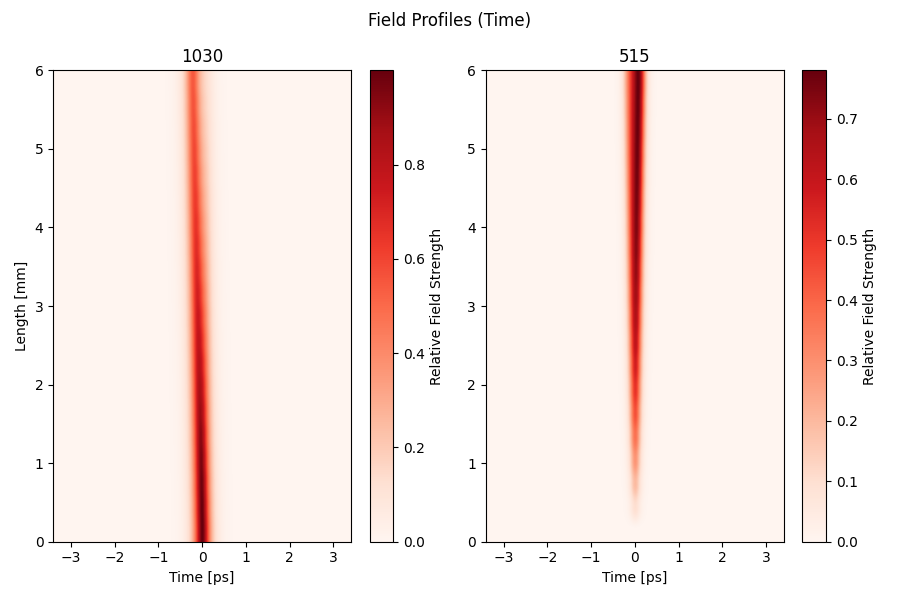

In [27]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
plt.imshow(np.abs(fftshift(crystalSHG.signalTimes(0)[::100], axes=1)), cmap="Reds", aspect="auto", origin="lower",
           extent=[-tMax * timeScale, tMax * timeScale, 0, 1000 * length1])
plt.colorbar(label="Relative Field Strength")
plt.title("1030")
plt.ylabel("Length [mm]")
plt.xlabel("Time [ps]")

ax = fig.add_subplot(1, 2,  2)
plt.imshow(np.abs(fftshift(crystalSHG.signalTimes(1)[::100], axes=1)), cmap="Reds", aspect="auto", origin="lower",
           extent=[-tMax * timeScale, tMax * timeScale, 0, 1000 * length1])
plt.colorbar(label="Relative Field Strength")
plt.title("515")
plt.xlabel("Time [ps]")

plt.suptitle("Field Profiles (Time)")
plt.tight_layout()

<IPython.core.display.Javascript object>


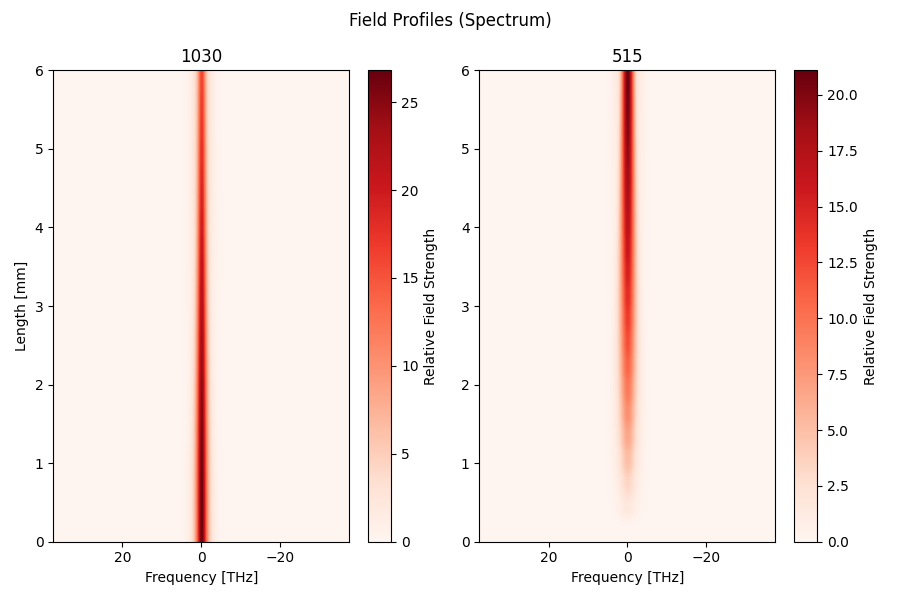

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
plt.imshow(np.abs(fftshift(crystalSHG.signalFreqs(0)[::100], axes=1)), cmap="Reds", aspect="auto", origin="lower",
           extent=[angFreqMax / (2 * np.pi), -angFreqMax / (2 * np.pi), 0, 1000 * length1])
plt.colorbar(label="Relative Field Strength")
plt.title("1030")
plt.ylabel("Length [mm]")
plt.xlabel("Frequency [THz]")

ax = fig.add_subplot(1, 2,  2)
plt.imshow(np.abs(fftshift(crystalSHG.signalFreqs(1)[::100], axes=1)), cmap="Reds", aspect="auto", origin="lower",
           extent=[angFreqMax / (2 * np.pi), -angFreqMax / (2 * np.pi), 0, 1000 * length1])
plt.colorbar(label="Relative Field Strength")
plt.title("515")
plt.xlabel("Frequency [THz]")

plt.suptitle("Field Profiles (Spectrum)")
plt.tight_layout()

<IPython.core.display.Javascript object>


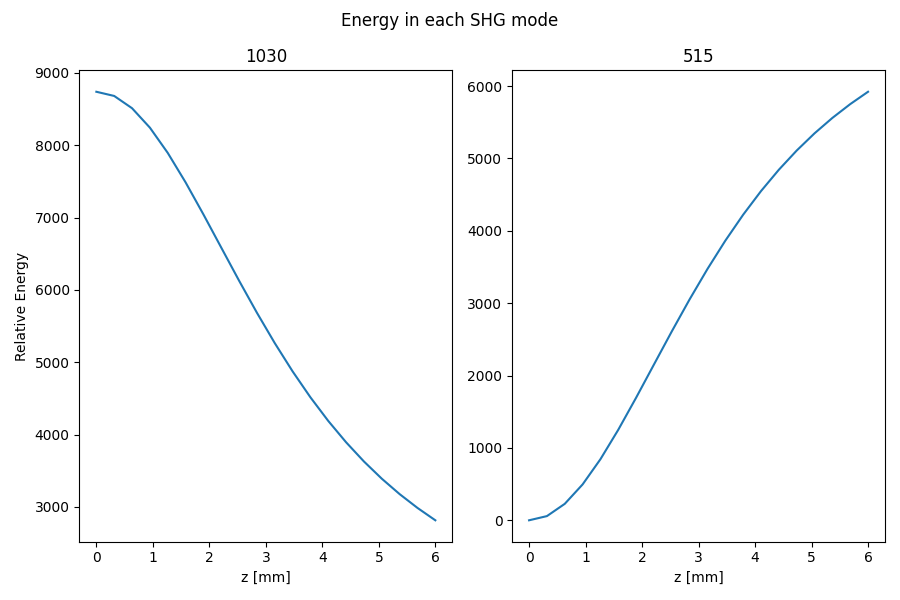

In [29]:
fig = plt.figure()

z = np.linspace(0, length1 * 1e3, crystalSHG.signalFreq.shape[0] // 100 + 1)

ax = fig.add_subplot(1, 2, 1)
plt.plot(z, np.sum(np.abs(crystalSHG.signalFreqs(0)[::100])**2, axis=1))
plt.title("1030")
plt.xlabel("z [mm]")
plt.ylabel("Relative Energy")

ax = fig.add_subplot(1, 2,  2)
plt.plot(z, np.sum(np.abs(crystalSHG.signalFreqs(1)[::100])**2, axis=1))
plt.title("515")
plt.xlabel("z [mm]")

plt.suptitle("Energy in each SHG mode")
plt.tight_layout()

# OPA Simulation

In [30]:
crystalOPA.runSignalSimulation(np.concatenate([np.zeros(nt),
                                               crystalSHG.signalTimes(1)[-1] * (indexH1 / indexH2),
                                               seed]),
                               inTimeDomain=True)

<IPython.core.display.Javascript object>


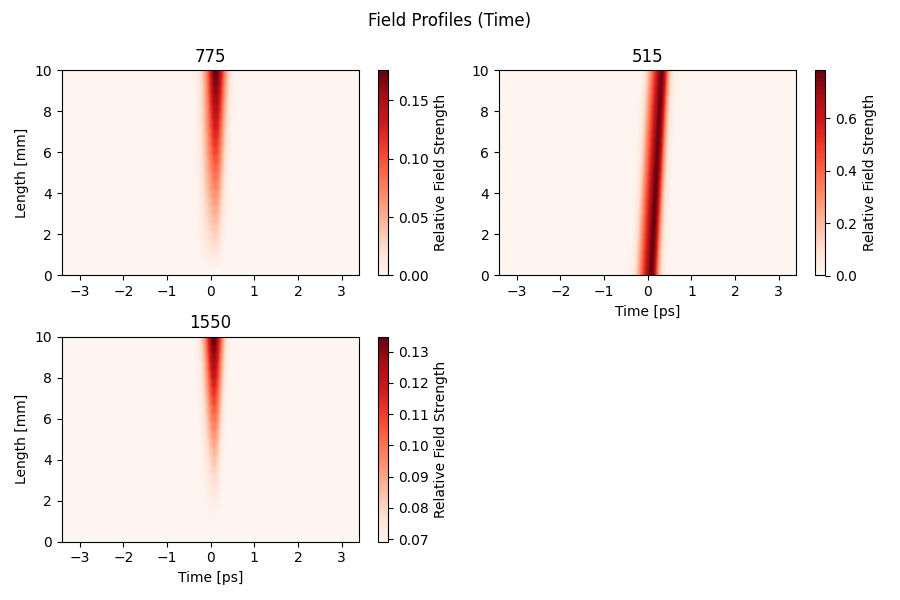

In [31]:
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
plt.imshow(np.abs(fftshift(crystalOPA.signalTimes(0)[::100], axes=1)), cmap="Reds", aspect="auto", origin="lower",
           extent=[-tMax * timeScale, tMax * timeScale, 0, 1000 * length2])
plt.colorbar(label="Relative Field Strength")
plt.title("775")
plt.ylabel("Length [mm]")

ax = fig.add_subplot(2, 2,  2)
plt.imshow(np.abs(fftshift(crystalOPA.signalTimes(1)[::100], axes=1)), cmap="Reds", aspect="auto", origin="lower",
           extent=[-tMax * timeScale, tMax * timeScale, 0, 1000 * length2])
plt.colorbar(label="Relative Field Strength")
plt.title("515")
plt.xlabel("Time [ps]")

ax = fig.add_subplot(2, 2, 3)
plt.imshow(np.abs(fftshift(crystalOPA.signalTimes(2)[::100], axes=1)), cmap="Reds", aspect="auto", origin="lower",
           extent=[-tMax * timeScale, tMax * timeScale, 0, 1000 * length2])
plt.colorbar(label="Relative Field Strength")
plt.title("1550")
plt.ylabel("Length [mm]")
plt.xlabel("Time [ps]")

plt.suptitle("Field Profiles (Time)")
plt.tight_layout();

<IPython.core.display.Javascript object>


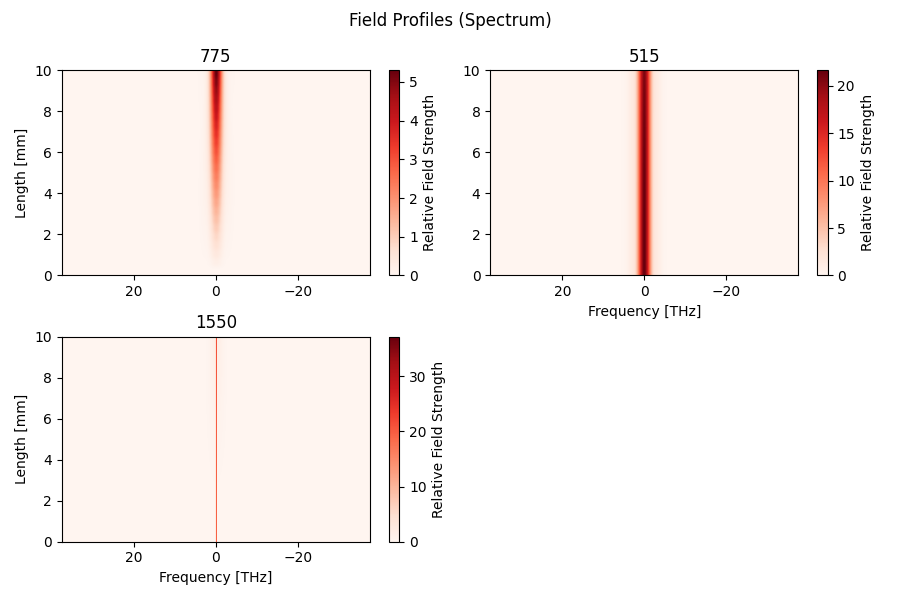

In [32]:
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
plt.imshow(np.abs(fftshift(crystalOPA.signalFreqs(0)[::100], axes=1)), cmap="Reds", aspect="auto", origin="lower",
           extent=[angFreqMax / (2 * np.pi), -angFreqMax / (2 * np.pi), 0, 1000 * length2])
plt.colorbar(label="Relative Field Strength")
plt.title("775")
plt.ylabel("Length [mm]")

ax = fig.add_subplot(2, 2,  2)
plt.imshow(np.abs(fftshift(crystalOPA.signalFreqs(1)[::100], axes=1)), cmap="Reds", aspect="auto", origin="lower",
           extent=[angFreqMax / (2 * np.pi), -angFreqMax / (2 * np.pi), 0, 1000 * length2])
plt.colorbar(label="Relative Field Strength")
plt.title("515")
plt.xlabel("Frequency [THz]")

ax = fig.add_subplot(2, 2, 3)
plt.imshow(np.abs(fftshift(crystalOPA.signalFreqs(2)[::100], axes=1)), cmap="Reds", aspect="auto", origin="lower",
           extent=[angFreqMax / (2 * np.pi), -angFreqMax / (2 * np.pi), 0, 1000 * length2])
plt.colorbar(label="Relative Field Strength")
plt.title("1550")
plt.ylabel("Length [mm]")
plt.xlabel("Frequency [THz]")

plt.suptitle("Field Profiles (Spectrum)")
plt.tight_layout()

<IPython.core.display.Javascript object>


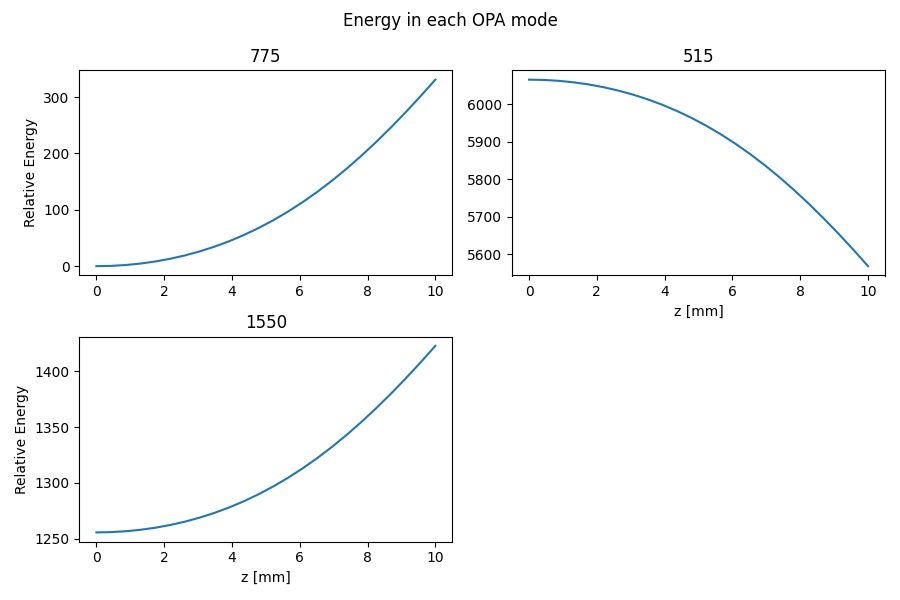

In [33]:
fig = plt.figure()

z = np.linspace(0, length2 * 1e3, crystalOPA.signalFreq.shape[0] // 100 + 1)

ax = fig.add_subplot(2, 2, 1)
plt.plot(z, np.sum(np.abs(crystalOPA.signalFreqs(0)[::100])**2, axis=1))
plt.title("775")
plt.ylabel("Relative Energy")

ax = fig.add_subplot(2, 2,  2)
plt.plot(z, np.sum(np.abs(crystalOPA.signalFreqs(1)[::100])**2, axis=1))
plt.title("515")
plt.xlabel("z [mm]")

ax = fig.add_subplot(2, 2, 3)
plt.plot(z, np.sum(np.abs(crystalOPA.signalFreqs(2)[::100])**2, axis=1))
plt.title("1550")
plt.xlabel("z [mm]")
plt.ylabel("Relative Energy")

plt.suptitle("Energy in each OPA mode")
plt.tight_layout()

Energy conservation throughout the simulation 

<IPython.core.display.Javascript object>


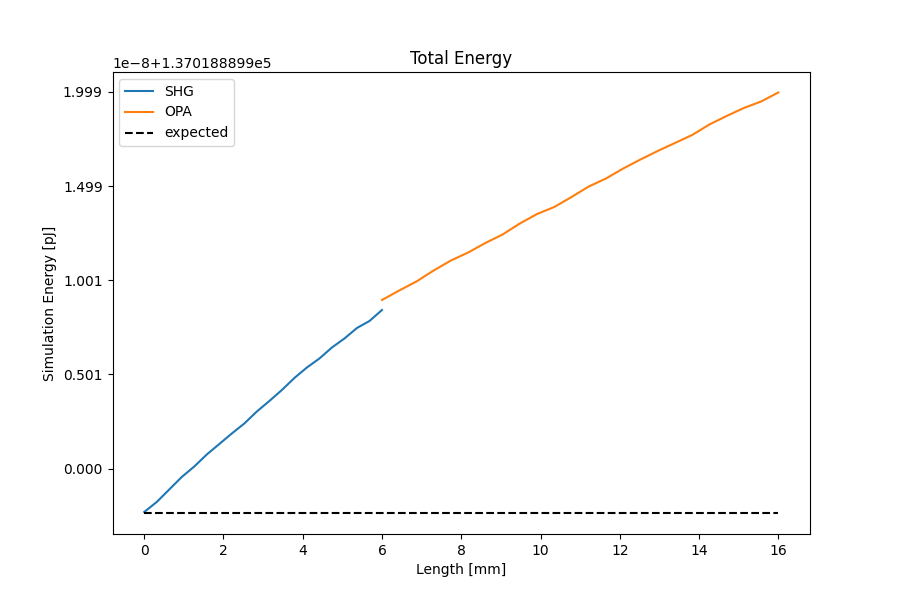

In [34]:
fig = plt.figure()

dt = time[1] / 2

z = np.linspace(0, length1 * 1e3, crystalSHG.signalFreq.shape[0] // 100 + 1)

plt.plot(z,
         np.sum(np.abs(crystalSHG.signalTimes(0)[::100])**2, axis=1) * peakPower * dt
       + np.sum(np.abs(crystalSHG.signalTimes(1)[::100])**2, axis=1) * peakPower * dt * (indexH1 / indexP)**2
       + np.sum(np.abs(crystalOPA.signalTimes(2)[0])**2) * peakPower * dt * (indexS / indexP)**2,
        label="SHG")

z = np.linspace(0, length2 * 1e3, crystalOPA.signalFreq.shape[0] // 100 + 1) + length1 * 1e3

plt.plot(z,
         np.sum(np.abs(crystalOPA.signalTimes(0)[::100])**2, axis=1) * peakPower * dt * (indexI  / indexP)**2
       + np.sum(np.abs(crystalOPA.signalTimes(1)[::100])**2, axis=1) * peakPower * dt * (indexH2 / indexP)**2
       + np.sum(np.abs(crystalOPA.signalTimes(2)[::100])**2, axis=1) * peakPower * dt * (indexS  / indexP)**2
       + np.sum(np.abs(crystalSHG.signalTimes(0)[-1])**2) * dt * peakPower,
        label="OPA")

totalEnergy = energy * 1e12 + power * tMax * timeScale #* 2 # pJ
plt.plot([0, (length1 + length2) * 1e3], [totalEnergy, totalEnergy], "--k", label="expected")

plt.xlabel("Length [mm]")
plt.ylabel("Simulation Energy [pJ]")
plt.title("Total Energy")
plt.legend();

In [35]:
print("Energy of original 1030 nm pulse: {:.0f} pJ".format(
np.sum(np.abs(fftshift(crystalSHG.signalTimes(0)[0]))**2) * peakPower * dt))

Energy of original 1030 nm pulse: 120000 pJ


In [36]:
print("Energy of generated 775 nm pulse: {:.0f} pJ".format(
np.sum(np.abs(crystalOPA.signalTimes(0)[-1])**2) * peakPower * indexI / indexP * dt))

Energy of generated 775 nm pulse: 4766 pJ


<IPython.core.display.Javascript object>


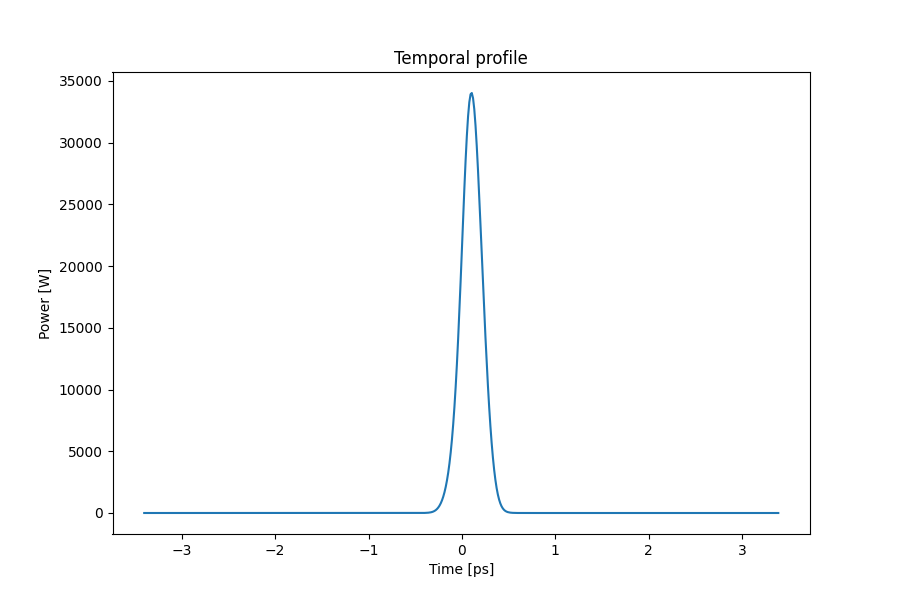

In [37]:
fig = plt.figure()

plt.plot(fftshift(time), np.abs(fftshift(crystalOPA.signalTimes(0)[-1]))**2 \
         * peakPower * indexI / indexP)
plt.xlabel("Time [ps]")
plt.ylabel("Power [W]")
plt.title("Temporal profile");

<IPython.core.display.Javascript object>


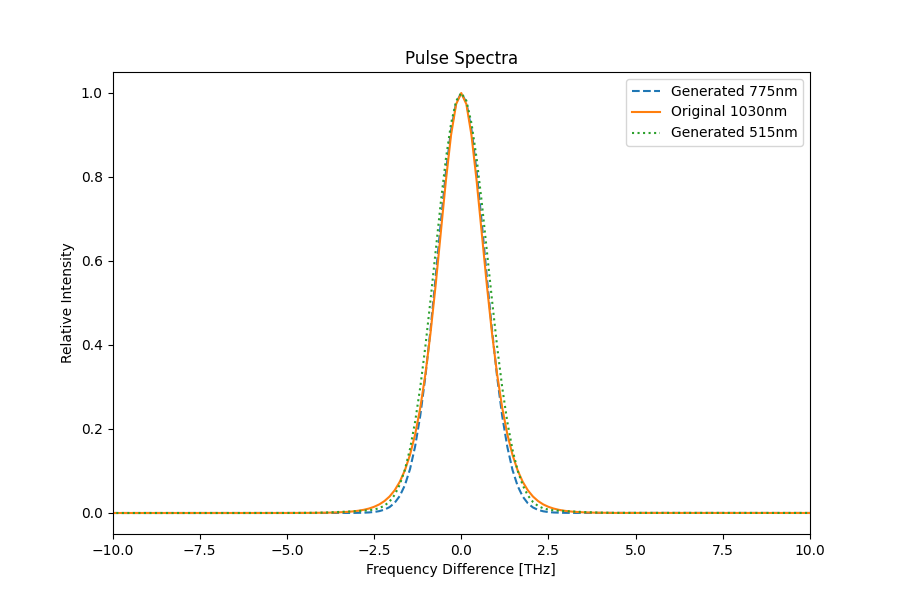

In [38]:
fig = plt.figure()

normSignSpectrum = np.abs(fftshift(crystalOPA.signalFreqs(0)[-1]))**2
normPumpSpectrum = np.abs(fftshift(pumpProfFreq))**2
normSHGSpectrum  = np.abs(fftshift(crystalSHG.signalFreqs(1)[-1]))**2

normSignSpectrum /= np.max(normSignSpectrum)
normPumpSpectrum /= np.max(normPumpSpectrum)
normSHGSpectrum  /= np.max(normSHGSpectrum)

plt.plot(fftshift(angFreq / (2 * np.pi)), normSignSpectrum, "--", label="Generated 775nm")
plt.plot(fftshift(angFreq / (2 * np.pi)), normPumpSpectrum, "-", label="Original 1030nm")
plt.plot(fftshift(angFreq / (2 * np.pi)), normSHGSpectrum,  ":", label="Generated 515nm")
plt.xlim(-10, 10)

plt.legend()
plt.xlabel("Frequency Difference [THz]")
plt.ylabel("Relative Intensity")
plt.title("Pulse Spectra");

<IPython.core.display.Javascript object>


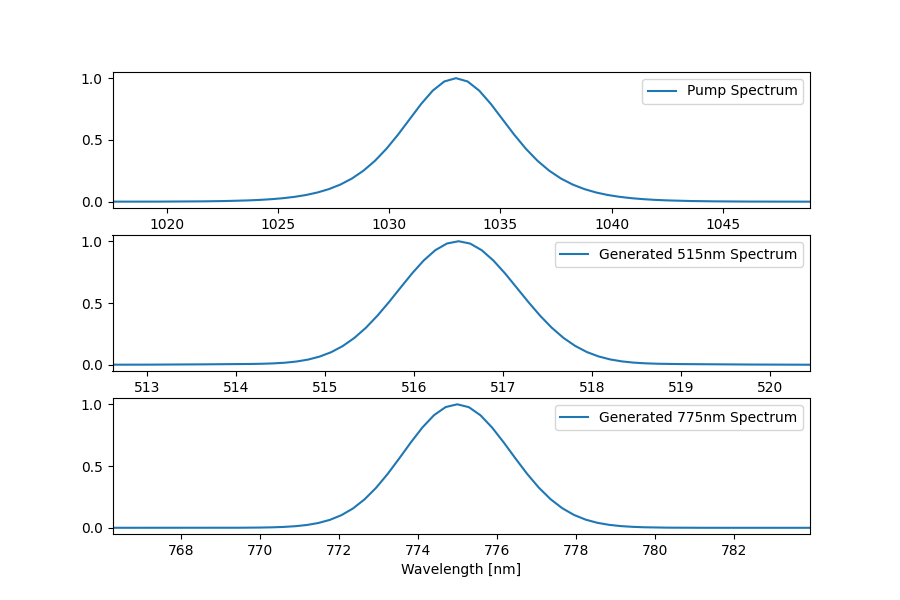

In [39]:
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.plot(fftshift(wavelengthP), normPumpSpectrum, label="Pump Spectrum")
plt.xlim((wavelengthP[-30], wavelengthP[30]))
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(fftshift(wavelengthH), normSHGSpectrum, label="Generated 515nm Spectrum")
plt.xlim((wavelengthH[-30], wavelengthH[30]))
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(fftshift(wavelengthI), normSignSpectrum, label="Generated 775nm Spectrum")
plt.xlim((wavelengthI[-30], wavelengthI[30]))
plt.legend()
plt.xlabel("Wavelength [nm]");

# Power noise: input vs output
Since the OPA amplifies the fluctuations, calculate how the power in the input affects the output. 

In [40]:
powerFluctuation = np.linspace(0.98, 1.02, 21)
powerOutput = np.zeros((powerFluctuation.size, powerFluctuation.size))

for i, pumpRelPower in enumerate(powerFluctuation):
  crystalSHG.runSignalSimulation(pumpRelPower * pumpProfTemp, inTimeDomain=True, inputMode=0)
  for j, signalRelPower in enumerate(powerFluctuation):
    crystalOPA.runSignalSimulation(np.concatenate([np.zeros(nt),
                                                   crystalSHG.signalTimes(1)[-1] * (indexH1 / indexH2),
                                                   signalRelPower * seed]),
                                   inTimeDomain=True)
    powerOutput[i, j] = np.sum(np.abs(crystalOPA.signalTimes(0)[-1])**2) * peakPower * indexI / indexP * dt

<IPython.core.display.Javascript object>


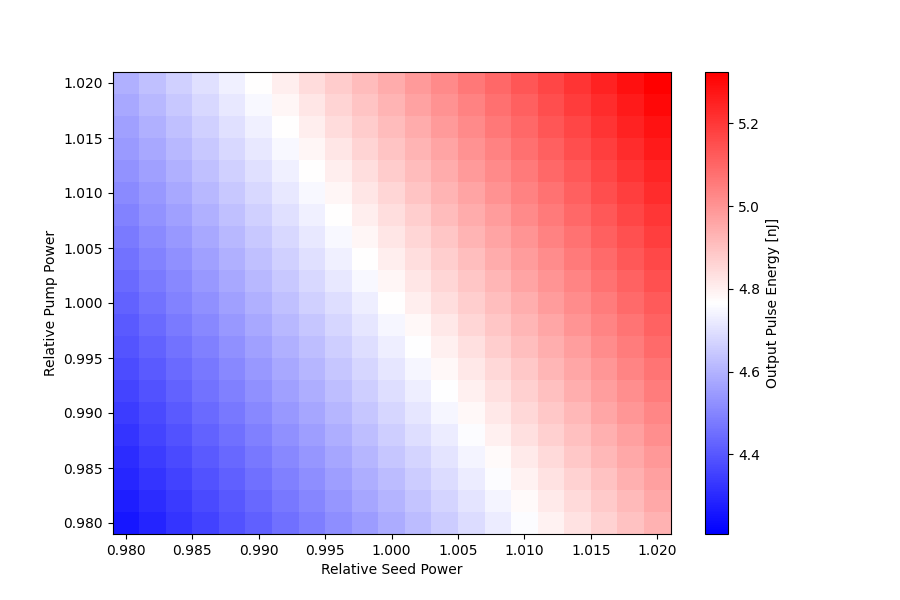

In [41]:
fig = plt.figure()

centerValue = powerOutput[powerFluctuation.size//2, powerFluctuation.size//2]
maxDiff = max(abs(centerValue - powerOutput.min()), abs(powerOutput.max() - centerValue))

plt.pcolormesh(powerFluctuation, powerFluctuation, powerOutput.T / 1000, cmap="bwr", rasterized=True,
               vmin=(centerValue-maxDiff) / 1000, vmax=(centerValue+maxDiff) / 1000)

plt.ylabel("Relative Pump Power")
plt.xlabel("Relative Seed Power")
plt.colorbar().set_label("Output Pulse Energy [nJ]");

Plot slices:

<IPython.core.display.Javascript object>


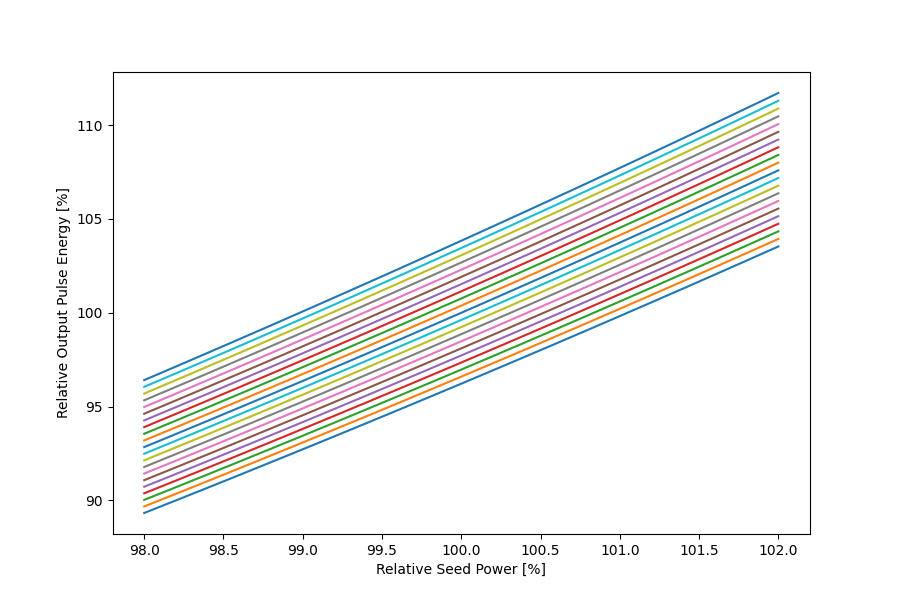

In [42]:
fig = plt.figure()

plt.plot(100 * powerFluctuation,
         powerOutput / (1e-2 * powerOutput[powerFluctuation.size//2, powerFluctuation.size//2]))

plt.xlabel("Relative Seed Power [%]")
plt.ylabel("Relative Output Pulse Energy [%]");

<IPython.core.display.Javascript object>


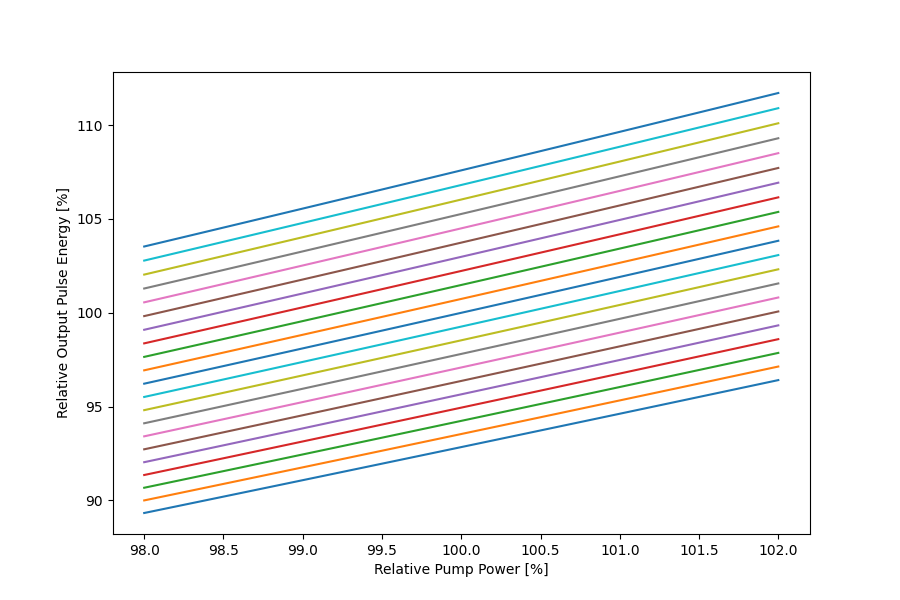

In [43]:
fig = plt.figure()

plt.plot(100 * powerFluctuation,
         powerOutput.T / (1e-2 * powerOutput[powerFluctuation.size//2, powerFluctuation.size//2]))

plt.xlabel("Relative Pump Power [%]")
plt.ylabel("Relative Output Pulse Energy [%]");